In [3]:
from __future__ import print_function, division
import logging
import sys
import os
from pathlib import Path
DATA_DIR = \
    Path(r'/media/ariel/6EEE7AB0EE7A7067/Users/Ariel/Documents/DS הכשרה_/15. MDE with laser reference '
         r'point/laser-mde/data')
import random
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:

print('\n******\npart 1\n*******')
warnings.filterwarnings("ignore")
print("data dir: ", DATA_DIR)
plt.ion()  # interactive mode
depth_path = os.path.join(DATA_DIR, 'farsight', 'depth-in-meters')
img_path = os.path.join(DATA_DIR, 'farsight', 'img')
# depth and img filenames are the same, just in different folders.

filenames = [fn for fn in os.listdir(img_path) if fn.lower().endswith('.png')]
img_name = filenames[1]

img = io.imread(os.path.join(img_path, img_name))
depth = io.imread(os.path.join(depth_path, img_name))
print('Image name: {}'.format(img_name))
print('Imgae type: {}'.format(type(img)))
print('Image shape: {}'.format(img.shape))
print('Depth shape: {}'.format(depth.shape))
print('Depth value range:\nmin:{0}\nmax:{1}'.format(np.min(depth), np.max(depth)))
print('some depth values: {}'.format(depth[0, :2]))




******
part 1
*******
data dir:  /media/ariel/6EEE7AB0EE7A7067/Users/Ariel/Documents/DS הכשרה_/15. MDE with laser reference point/laser-mde/data
Image name: ny_brooklyn5_3_H_6_000038.png
Imgae type: <class 'numpy.ndarray'>
Image shape: (513, 513, 3)
Depth shape: (513, 513)
Depth value range:
min:0
max:981
some depth values: [42 42]


In [5]:

def get_full_depth_path(fn):
    return os.path.join(depth_path, fn)


def get_full_img_path(fn):
    return os.path.join(img_path, fn)


def show_image_depth_pair(image, depth):
    """Show image with depth map"""
    plt.subplot(121)
    plt.imshow(image)
    plt.title('image')
    plt.subplot(122)
    plt.imshow(depth)
    # axs[1].set_title('depth')
    plt.title('depth')
    plt.tight_layout()





******
part 2
*******


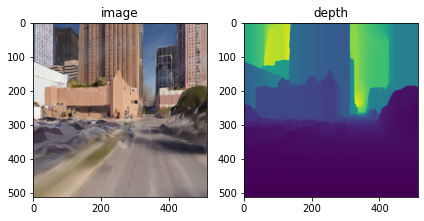

In [6]:
print('\n******\npart 2\n*******')
plt.figure()
show_image_depth_pair(img, depth)
plt.show()


In [78]:


class FarsightDataset(Dataset):
    """Farsight dataset with (img,depth) pairs."""

    def __init__(self, img_dir, depth_dir, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            depth_dir (string): Directory with all the depth images
                  (with same name as its corresponding image).
            transform (callable, optional): Optional transform to be applied
                  on a sample.
        """
        self.img_dir = img_dir
        self.depth_dir = depth_dir
        self.transform = transform
        self.filenames = np.array([fn for fn in os.listdir(img_path) if fn.lower().endswith('.png')])
        self.filenames.sort()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # batch requests
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir,
                                self.filenames[idx])
        depth_name = os.path.join(self.depth_dir,
                                  self.filenames[idx])
        image = io.imread(img_name)
        depth = io.imread(depth_name)
        sample = {'image': image, 'depth': depth, 'name': self.filenames[idx].strip('.png')}

        if self.transform:
            sample = self.transform(sample)

        return sample




******
part 3
*******
0 (513, 513, 3) (513, 513)
1 (513, 513, 3) (513, 513)
2 (513, 513, 3) (513, 513)
3 (513, 513, 3) (513, 513)


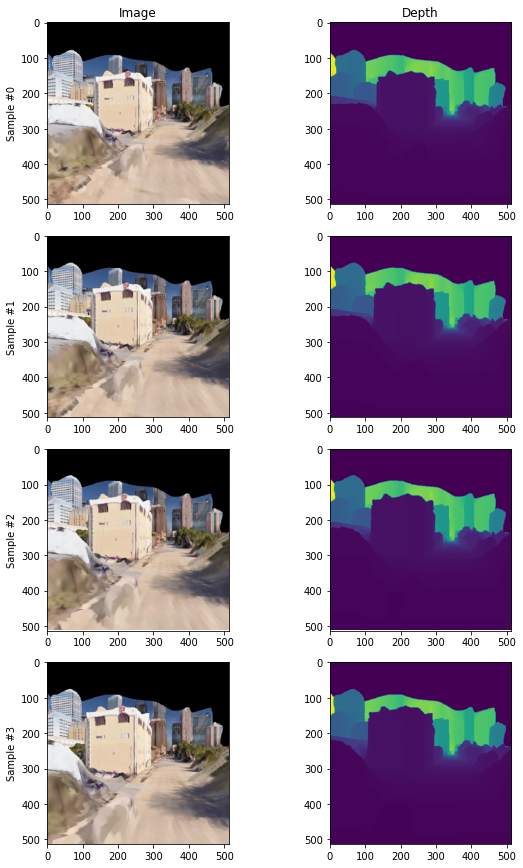

In [79]:

print('\n******\npart 3\n*******')
farsight_dataset = FarsightDataset(img_dir=img_path,
                                   depth_dir=depth_path)

# fig = plt.figure()
fig, axs = plt.subplots(4, 2, figsize=(8, 12))
fig.tight_layout()
# axs[0, 0].set_title('Image')
# axs[0, 1].set_title('Depth')
for i in range(len(farsight_dataset)):
    # random.randint(0, len(farsight_dataset))
    sample = farsight_dataset[i]
    ax = plt.subplot(4, 2, 2 * i + 1)
    if i == 0:
        ax.set_title('Image')
    print(i, sample['image'].shape, sample['depth'].shape)
    ax.set_ylabel('Sample #{}'.format(i))
    plt.imshow(sample['image'])
    ax = plt.subplot(4, 2, 2 * i + 2)
    if i == 0:
        ax.set_title('Depth')
    plt.imshow(sample['depth'])
    if i == 3:
        plt.show()
        break



In [80]:

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        # depth = depth[np.newaxis]
        # depth is just H X W, so no problem here.
        return {'image': torch.from_numpy(image),
                'depth': torch.from_numpy(np.int16(depth)),
                'name': sample['name']}


In [91]:


print('\n******\npart 4\n*******')
transformed_dataset = FarsightDataset(img_dir=img_path,
                                      depth_dir=depth_path,
                                      transform=ToTensor())
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['depth'].size(), sample['name'])

    if i == 3:
        break

dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True,num_workers=0)

print('\n******\npart 5\n*******')




******
part 4
*******
0 torch.Size([3, 513, 513]) torch.Size([513, 513]) houston_1_1_H_-16_000000
1 torch.Size([3, 513, 513]) torch.Size([513, 513]) houston_1_1_H_-16_000001
2 torch.Size([3, 513, 513]) torch.Size([513, 513]) houston_1_1_H_-16_000002
3 torch.Size([3, 513, 513]) torch.Size([513, 513]) houston_1_1_H_-16_000003

******
part 5
*******


In [92]:

# Helper function to show a batch
def show_depths_batch(sample_batched):
    """Show image with depths for a batch of samples."""
    images_batch, depths_batch, names = \
        sample_batched['image'], sample_batched['depth'], sample_batched['name']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    print('batch size: ', batch_size)
    fig, ax = plt.subplots(2,batch_size,figsize=(batch_size * 3,batch_size*1.5))
    plt.tight_layout()
    for i, img in enumerate(images_batch):
        if i == 0:
            ax[0,i].set_ylabel('image')
        ax[0,i].set_title('sample #{}\n{}'.format(i, names[i]))
        ax[0,i].imshow(img.numpy().transpose((1, 2, 0)))
    for i, depth in enumerate(depths_batch):
        if i == 0:
            ax[1,i].set_ylabel('depth')
        ax[1,i].imshow(depth)
    plt.show()
    print(depths_batch.size())
    print('depth min/max values: ',torch.min(depths_batch),torch.max(depths_batch))
    plt.show()


0 torch.Size([4, 3, 513, 513]) torch.Size([4, 513, 513])
1 torch.Size([4, 3, 513, 513]) torch.Size([4, 513, 513])
2 torch.Size([4, 3, 513, 513]) torch.Size([4, 513, 513])
3 torch.Size([4, 3, 513, 513]) torch.Size([4, 513, 513])
batch size:  4


<Figure size 432x288 with 0 Axes>

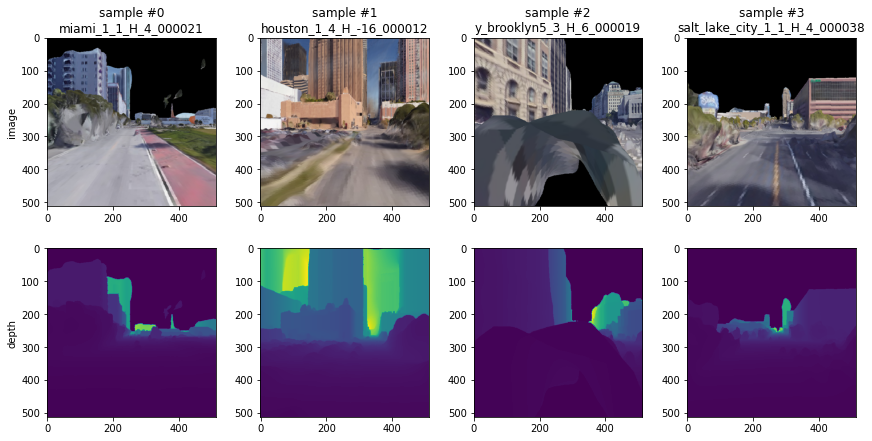

torch.Size([4, 513, 513])
depth min/max values:  tensor(0, dtype=torch.int16) tensor(785, dtype=torch.int16)


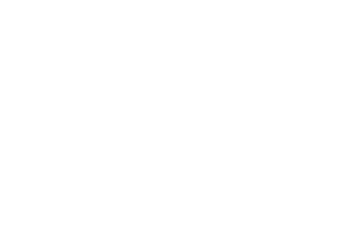

In [94]:

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['depth'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_depths_batch(sample_batched)
        
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
